In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *
# import os, sys, getpass
# user = getpass.getuser()
# sys.path.append(f'/home/{user}/codes/hpe_library/')
# from hpe_library.lib_import import *
# from hpe_library. my_utils import *
# os.chdir('/home/hrai/codes/MotionBERT')

In [2]:
data_type_list = ['source_list', 'cam_param', 
                  'world_3d', 'cam_3d', 'img_2d', 
                  #'img_3d', 'scale_factor', 'img_25d', 
                  #'cam_3d_canonical_same_z', 'img_2d_canonical_same_z', 
                  #'cam_3d_canonical_same_dist', 'img_2d_canonical_same_dist',
                  'cam_3d_canonical_fixed_dist_5', 'img_2d_canonical_fixed_dist_5']
overwrite_list = []
h36m = load_data_dict('h36m', data_type_list, overwrite_list, verbose=False)
fit3d = load_data_dict('fit3d', data_type_list, overwrite_list, verbose=False)
_3dhp = load_data_dict('3dhp', data_type_list, overwrite_list, verbose=False)

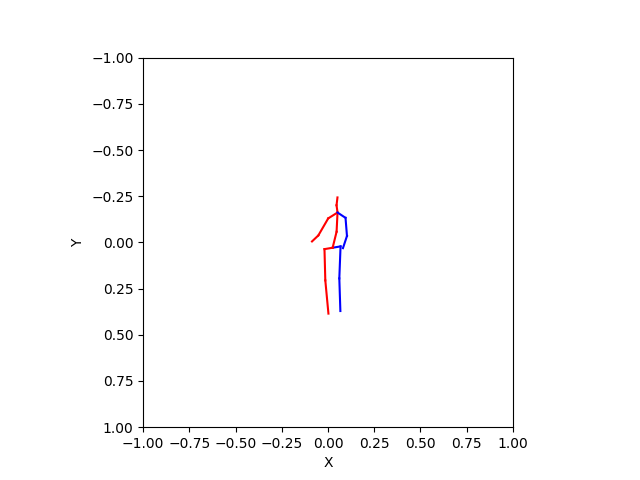

(0.18921103258181682, 0.6286762908866589, 1000.0, 1002.0)

In [6]:
dataset_name = 'h36m'
if dataset_name == 'h36m': data = h36m.copy()
elif dataset_name == 'fit3d': data = fit3d.copy()
elif dataset_name == '3dhp': data = _3dhp.copy()
source = data['source_list'][0]
subject, cam_id, action = split_source_name(source, dataset_name)
cam_3d_canonical_fixed_dist_5 = data['cam_3d_canonical_fixed_dist_5'][subject][action][cam_id]
cam_param = data['cam_param'][subject][action][cam_id]
R, t, C, W, H = cam_param['R'], cam_param['t'], cam_param['C'], cam_param['W'], cam_param['H']
intrinsic = np.array(cam_param['intrinsic'])
intrinsic[0][0] = W
intrinsic[1][1] = H
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

frame_num = 0
img = cam_3d_canonical_fixed_dist_5[frame_num] @ intrinsic.T
img = img / img[:, 2][:, None]
img_norm = normalize_input(img, W, H)

fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig)
#draw_2d_pose(ax, img, W=W, H=H)
draw_2d_pose(ax, img_norm, normalize=True)
plt.show()

x_max = img_norm[:, 0].max()
x_min = img_norm[:, 0].min()
y_max = img_norm[:, 1].max()
y_min = img_norm[:, 1].min()
x_max - x_min, y_max - y_min, fx, fy

In [66]:
for dataset_name in ['h36m', 'fit3d', '3dhp']:
    if dataset_name == 'h36m': data = h36m.copy()
    elif dataset_name == 'fit3d': data = fit3d.copy()
    elif dataset_name == '3dhp': data = _3dhp.copy()

    cam_3d_canonicals = data['cam_3d_canonical_fixed_dist_5']
    source_list = data['source_list']
    cam_params = data['cam_param']
    img_2d_canonicals = {}
    img_2d_canonicals_array = []
    cam_params_array = []
    for source in source_list:
        if dataset_name == '3dhp':
            if 'TS' not in source: continue
        subject, cam_id, action = split_source_name(source, dataset_name)
        if subject not in img_2d_canonicals:          img_2d_canonicals[subject] = {}
        if action  not in img_2d_canonicals[subject]: img_2d_canonicals[subject][action] = {}
        cam_3d_canonical = cam_3d_canonicals[subject][action][cam_id]
        cam_param = cam_params[subject][action][cam_id]
        num_frames = cam_param['num_frames']
        cam_params_array += [cam_param] * num_frames
        R, t, C, W, H = cam_param['R'], cam_param['t'], cam_param['C'], cam_param['W'], cam_param['H']
        intrinsic = np.array(cam_param['intrinsic'])
        intrinsic[0][0] = W
        intrinsic[1][1] = H
        img_2d_canonical = np.einsum('ijk,kl->ijl', cam_3d_canonical, intrinsic.T) # (N, 17, 2)
        img_2d_canonical = img_2d_canonical / img_2d_canonical[:, :, 2:] # (N, 17, 2)
        img_2d_canonicals[subject][action][cam_id] = img_2d_canonical[...,:2]
        img_2d_canonicals_array += list(img_2d_canonical[...,:2])
    img_2d_canonicals_array = np.array(img_2d_canonicals_array)
    cam_params_array = np.array(cam_params_array)

    W_array = np.array([cam_param['W'] for cam_param in cam_params_array])
    H_array = np.array([cam_param['H'] for cam_param in cam_params_array])
    img_2d_canonicals_fixed_dist_5_fixed_focal_norm = img_2d_canonicals_array.copy()
    img_2d_canonicals_fixed_dist_5_fixed_focal_norm *= 2
    img_2d_canonicals_fixed_dist_5_fixed_focal_norm -= np.concatenate([W_array[:, None, None], H_array[:, None, None]], axis=2)
    img_2d_canonicals_fixed_dist_5_fixed_focal_norm /= W_array[:, None, None]

    x_max = np.max(img_2d_canonicals_fixed_dist_5_fixed_focal_norm[:, :, 0], axis=1)
    x_min = np.min(img_2d_canonicals_fixed_dist_5_fixed_focal_norm[:, :, 0], axis=1)
    y_max = np.max(img_2d_canonicals_fixed_dist_5_fixed_focal_norm[:, :, 1], axis=1)
    y_min = np.min(img_2d_canonicals_fixed_dist_5_fixed_focal_norm[:, :, 1], axis=1)
    print((x_max - x_min).mean(), (y_max - y_min).mean())

0.229270779103978 0.540257249146777
0.24627563165418526 0.5545716653498733
0.2854845214929337 0.5454425496041266
